# Set up

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod')) # <--- Ändra här

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SAFAD_interface import SAFAD_interface

In [3]:
# Create session object
session = cm.Session(
    name = 'SLV_v2',
    data_path = '../CIBUSmod/data',
    data_path_output = 'output',
    data_path_scenarios = 'scenarios'
)

SCN_NAME = 'SLV' # <--- Ändra här
BL_SCN = ('SLV','1')

In [4]:
def scn_tuple(y, long=False):
    pos_1 = {'1':'5%', '2':'30%'}
    pos_2 = {'1':'CMS','2':'SE','3':'SE-all'}
    pos_3 = {'1':'C','2':'PB'}
    pos_4 = {'0':'', '1':'+AP'}
    if long:
        pos_2 = {'1':'Current market shares','2':'Swedish','3':'Swedish (all consumers)'}
        pos_3 = {'1':'Chicken','2':'Plant-based'}
        pos_4 = {'0':'','1':' + Agricultural policy'}
    
    if y == '0':
        return ('BL','2016-2020','')
    if y == '1':
        return ('BL','2023','')
    else:
        return (pos_1[y[0]], pos_2[y[1]]+pos_4[y[3]], pos_3[y[2]], )
        
def make_scn_idx(idx):

    return pd.MultiIndex.from_tuples(
        [scn_tuple(y) for y in idx.get_level_values('year')],
        names = ['Compliance', 'Origin, meat', 'Substitute']
    )

CO2e_method = 'GWP100 AR6'

bar_style = {
    'cmap':'Accent',
    'group_levels':['Compliance','Substitute'],
    'grouplabels_fontsize':9,
    'ticklabels_fontsize':9,
    'grouptitle_fontsize':10,
    'ylabel_fontsize':10,
    'xlabel_fontsize':10,
    'xlabel':'Origion of red meat',
    'grouptitle':'Compliance and substitute',
}

bar_style2 = {k:v for k,v in bar_style.items() if k != 'cmap'}

def style_bar(ax, d):
    if isinstance(d, pd.DataFrame):
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1,1), frameon=False
        )
    ax.axhline(d.loc[scn_tuple(BL_SCN[1])].sum(), color='black', linestyle='--', linewidth=0.5)

def annotate_axs(axs, size=10, pos=(-0.2,1.3)):
    import string
    for i, ax in enumerate(axs.flatten()):
        ax.text(*pos, string.ascii_lowercase[i % 26],
                transform=ax.transAxes, fontsize=size,
                fontweight='bold', va='top', ha='right')

In [5]:
session.cache.clear()

# Calculate impacts from changed imports

In [6]:
SAFAD = SAFAD_interface('SAFAD_data')
SAFAD_sens = SAFAD_interface('SAFAD_data')
SAFAD.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_add_BR.csv') # <-- Add data from Brazil (also used for Argentina)
SAFAD_sens.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_sens.csv') # <-- Sensitivity analysis only Irish suckler cows for beef imports (Moberg)

to_SAFAD_codes = {
    'food' : pd.read_csv('food_to_SAFAD_codes.csv', index_col='food')['code'].dropna().to_dict(),
    'by_prod' : pd.read_csv('by_prod_to_SAFAD_codes.csv', index_col='by_prod')['code'].dropna().to_dict(),
    'crop_prod' : pd.read_csv('crop_prod_to_SAFAD_codes.csv', index_col='crop_prod')['code'].dropna().to_dict()
}

def get_ghg(SAFAD, df, CO2eq):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_GHG(to_SAFAD_codes[item][col], CO2eq=CO2eq)}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

def get_footprint(SAFAD, df, footprint):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_footprints(to_SAFAD_codes[item][col]).loc[footprint]}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

In [7]:
food_dict = {
    'Bovine meat and products' : '$\Delta$ red meat imports',
    'Broad beans and horse beans, dry' : '$\Delta$ substitute imports',
    'Mutton/goat meat' : '$\Delta$ red meat imports',
    'Peas, dry' : '$\Delta$ substitute imports',
    'Pig meat and products' : '$\Delta$ red meat imports',
    'Poultry meat and products' : '$\Delta$ substitute imports',
    'Rape and mustard oil and products' : '$\Delta$ substitute imports'
}

# Get food imports
food_import = session.get_attr('d','food_demand_to_processing',['origin','food']).loc[:,'imported']
# Calculate change from baseline and drop all foods with no change
food_import_chg = food_import.sub(food_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
food_import_chg.loc[food_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

# Adjust to align conversion factors CW --> BFM
# Clune et al (2017) are used in SAFAD data
food_import_chg.loc[:,'Bovine meat and products'] *= (0.695/0.70)
food_import_chg.loc[:,'Mutton/goat meat'] *= (0.66/0.88)
food_import_chg.loc[:,'Pig meat and products'] *= (0.59/0.78)
food_import_chg.loc[:,'Poultry meat and products'] *= (0.77/0.88)

food_import_CO2e_details = get_ghg(SAFAD, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_details_sens = get_ghg(SAFAD_sens, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_LUC_per_food = food_import_CO2e_details.xs('Land use change', level='process', axis=1).T.groupby('food').sum().T
food_import_CO2e_LUC = food_import_CO2e_details.xs('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e = food_import_CO2e_details.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_sens = food_import_CO2e_details_sens.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_GHG = get_ghg(SAFAD, food_import_chg, CO2eq=False).drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby(['food','compound']).sum().T
food_import_land = get_footprint(SAFAD, food_import_chg, 'Land').rename(columns=food_dict).T.groupby('food').sum().T / 10_000
food_import_ammonia = get_footprint(SAFAD, food_import_chg, 'Ammonia').rename(columns=food_dict).T.groupby('food').sum().T

In [8]:
# Get by-product imports
byprod_import = session.get_attr('d','by_products',['origin','by_prod']).loc[:,'imported']
# Get by-product exports
byprod_export = session.get_attr('d','by_prod_demand',['demand','by_prod']).loc[:,'export']
# Calculate net imports
byprod_import = byprod_import.sub(byprod_export, fill_value=0)
# Calculate change from baseline and drop all by-products with no change
byprod_import_chg = byprod_import.sub(byprod_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
byprod_import_chg.loc[byprod_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

byprod_import_CO2e_LUC = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).xs('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_CO2e = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_land = get_footprint(SAFAD, byprod_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
byprod_import_ammonia = get_footprint(SAFAD, byprod_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

# Get feed imports
feed_import = session.get_attr('a','feed.crop_product_demand',['origin','crop_prod']).loc[:,'imported']
# Calculate change from baseline and drop all by-products with no change
feed_import_chg = feed_import.sub(feed_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
feed_import_chg.loc[feed_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

feed_import_CO2e_LUC = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).xs('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_CO2e = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_land = get_footprint(SAFAD, feed_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
feed_import_ammonia = get_footprint(SAFAD, feed_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

feed_import_CO2e_LUC += byprod_import_CO2e_LUC
feed_import_CO2e += byprod_import_CO2e
feed_import_land += byprod_import_land
feed_import_ammonia += byprod_import_ammonia

In [9]:
# Changes in use of soybeans for feed [tonnes]
d = pd.concat([feed_import_chg,byprod_import_chg], axis=1).loc[:,['soybeans', 'soybean meal', 'soybean protein concentrate']] / 1_000
d.set_index(make_scn_idx(d.index), inplace=True)
d.to_clipboard()
d

soybeans  soybean meal  \
Compliance Origin, meat Substitute                             
BL         2016-2020                  0.000000      0.000000   
           2023                       0.000000      0.000000   
5%         CMS          C            -4.602864   2081.975478   
                        PB           -4.357982   -646.362471   
           CMS+AP       PB           -4.513121   -647.769965   
           SE           C             2.098745   2495.083405   
                        PB            2.343246   -233.257686   
           SE-all       C            99.976590  13200.306227   
                        PB          100.150934  10471.327376   
30%        CMS          C           -27.820116  12486.464475   
                        PB          -26.390388  -3883.923757   
           CMS+AP       PB          -26.832436  -3900.970615   
           SE           C            39.300682  15234.961202   
                        PB           49.445604  -1056.272138   
           SE-all       C            81.030595  22828.794150   
                        PB           83.632341   6469.050439   

                                    soybean protein concentrate  
Compliance Origin, meat Substitute                               
BL         2016-2020                                   0.000000  
           2023                                        0.000000  
5%         CMS          C                            -34.881322  
                        PB                           -34.881322  
           CMS+AP       PB                           -34.881322  
           SE           C                            -19.236716  
                        PB                           -19.236716  
           SE-all       C                            414.746432  
                        PB                           414.746432  
30%        CMS          C                           -209.288074  
                        PB                          -209.288074  
           CMS+AP       PB                          -209.288589  
           SE           C                           -115.419433  
                        PB                          -115.419433  
           SE-all       C                            204.356904  
                        PB                           204.356904

# Calculate impacts from LUC in Sweden

In [10]:
# Emission factors for LUC derived from Sweden's national inventory reports
# Averaged over 10 year (2013-2022). kg CO2 per ha
EF_cropland_to_forest = -1779
EF_grassland_to_forest = -1399
EF_forest_to_cropland = 7605
EF_forest_to_grassland = 9287
EF_land_to_cropland = 2207
EF_land_to_grassland = 3569

# Amortization period for LUC emissions, same as in Pendrill et al. (2019)
# "Agricultural and forestry trade drives large share of tropical deforestation emissions"
amort_period = 1

EF = pd.Series({
    'cropland':EF_land_to_cropland,
    'semi-natural grasslands':EF_land_to_grassland
})

swe_LUC = (
    session.get_attr('c','area',{'crop':'land_use'})
    .drop('greenhouse', axis=1)
    .pipe(lambda df: df - df.loc[BL_SCN])
    .mul(EF, axis=1)
    .div(amort_period)
    .rename(columns=lambda s: '$\Delta$ ' + s)
)
# Zero for BL scenarios
swe_LUC.loc[swe_LUC.index.get_level_values('year').astype(int) < 1000] = 0

# Cropland use

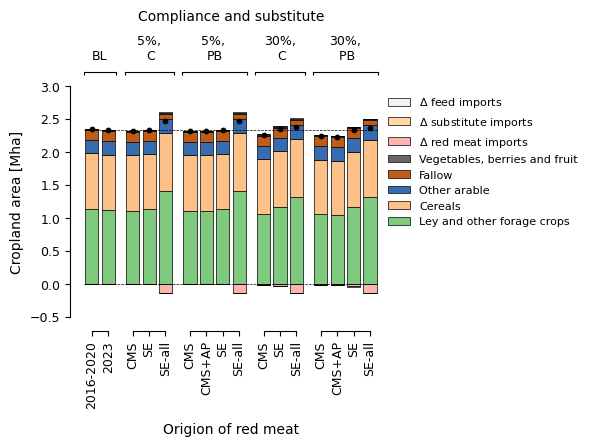

In [53]:
from matplotlib.colors import ListedColormap
colors = [plt.colormaps['Accent'](i/4) for i in range(5)]\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    session.get_attr('c','area',{'crop':['land_use','crop_group2']})
    .loc[:,'cropland']
    .sort_values(axis=1, by=('SLV','0'), ascending=False)
    .rename(columns={'Fodder crops':'Ley and other forage crops'})
    .join(food_import_land)
    .join(feed_import_land)
) / 1_000_000
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Cropland area [Mha]',
    ylim=(-0.5,3),
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2
)
style_bar(ax, d)
plt.savefig('output/figs/cropland.png',dpi=200,bbox_inches='tight')
plt.show()
d.to_csv('output/cropland_Mha.csv')

t = d.iloc[:,0:5].sum(axis=1)
t = (t-t.loc[scn_tuple(BL_SCN[1])]) / t.iloc[0] * 100
display(t.to_frame().style.format(precision=1))

t = d.iloc[:,0:5].sum(axis=1)
display(t.to_frame().style.format(precision=1))

In [12]:
session.get_attr('c','area','crop').loc[:,'Fallow']/1_000

scn  year
SLV  0       152.174932
     1       152.177200
     1110    152.185998
     1120    152.216133
     1121    152.216354
     1210    152.174141
     1220    152.201239
     1310     75.809990
     1320     75.811039
     2110    152.233700
     2120    152.653406
     2121    152.676579
     2210    152.184978
     2220    152.412599
     2310     76.065486
     2320     76.091373
Name: Fallow, dtype: float64

In [13]:
session.get_attr('c','area','crop').loc[:,'Ley not harvested']/1_000

scn  year
SLV  0       50.872603
     1       50.867606
     1110    50.870097
     1120    50.882017
     1121    50.882087
     1210    50.865775
     1220    50.876038
     1310    10.098859
     1320    10.099238
     2110    50.884587
     2120    51.080624
     2121    51.091749
     2210    50.865775
     2220    50.961786
     2310    10.166282
     2320    10.169745
Name: Ley not harvested, dtype: float64

# Semi-natural grasslands

In [14]:


(
    session.get_attr('c','area','crop')
    .loc[:,['Semi-natural pastures','Ley for grazing']]
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
)

crop      Semi-natural pastures  Ley for grazing
scn year                                        
SLV 0                 52.935955        47.064045
    1                 53.059699        46.940301
    1110              53.146328        46.853672
    1120              53.140603        46.859397
    1121              53.489953        46.510047
    1210              52.996747        47.003253
    1220              52.991780        47.008220
    1310              47.803858        52.196142
    1320              47.803562        52.196438
    2110              53.442189        46.557811
    2120              53.349485        46.650515
    2121              56.377842        43.622158
    2210              52.479675        47.520325
    2220              52.433498        47.566502
    2310              48.657284        51.342716
    2320              48.652853        51.347147

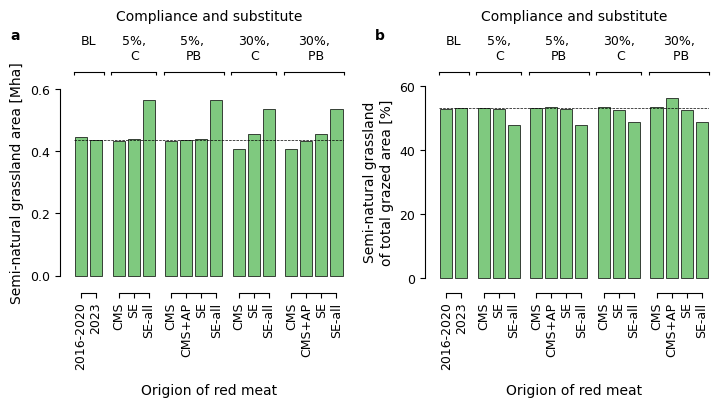

Compliance  Origin, meat  Substitute
BL          2016-2020                   52.935955
            2023                        53.059699
5%          CMS           C             53.146328
                          PB            53.140603
            CMS+AP        PB            53.489953
            SE            C             52.996747
                          PB            52.991780
            SE-all        C             47.803858
                          PB            47.803562
30%         CMS           C             53.442189
                          PB            53.349485
            CMS+AP        PB            56.377842
            SE            C             52.479675
                          PB            52.433498
            SE-all        C             48.657284
                          PB            48.652853
Name: Semi-natural pastures, dtype: float64

In [52]:
fig,axs = plt.subplots(1,2, figsize=(8.2,2.5), gridspec_kw={'wspace':0.35})

d1 = (
    session.get_attr('c','area',{'crop':['land_use']})
    .loc[:,'semi-natural grasslands']
) / 1_000_000
d1.index = make_scn_idx(d1.index)
ax = axs[0]
ax, axgs = cm.plot.bar(
    d1,
    ax = ax,
    ylabel='Semi-natural grassland area [Mha]',
    **bar_style,
    ylim=(-0.01,0.61)
)
style_bar(ax, d1)
d1.to_csv('output/SNG_Mha.csv')

d2 = (
    session.get_attr('c','area','crop')
    .loc[:,['Semi-natural pastures','Ley for grazing']]
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
    .loc[:,'Semi-natural pastures']
)
d2.index = make_scn_idx(d2.index)

ax = axs[1]
cm.plot.bar(
    d2,
    ax = ax,
    ylabel='Semi-natural grassland\nof total grazed area [%]',
    **bar_style,
    ylim = (-0.1,60)
)
style_bar(ax, d2)

annotate_axs(axs)
plt.savefig('output/figs/SNG.png',dpi=200,bbox_inches='tight')
plt.show()
t = (d1-d1.loc[scn_tuple(BL_SCN[1])]).div(d1.loc[scn_tuple(BL_SCN[1])]).mul(100)
display(t.to_frame().style.format(precision=1))

display(d2)

<Axes: >

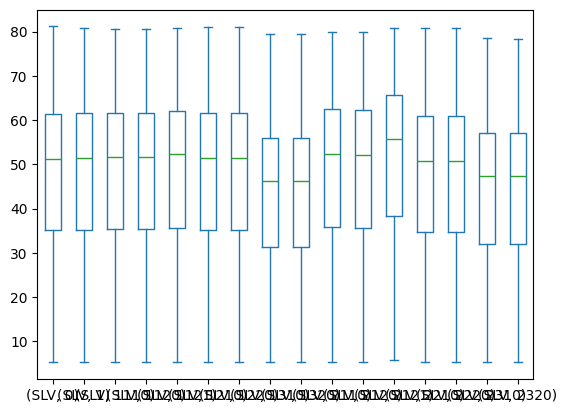

In [17]:
d=(
    session.get_attr('c','area',['crop','region'])
    .loc[:,['Semi-natural pastures','Ley for grazing']]
    .rename(columns=lambda x: x.capitalize())
    .T.groupby('region')
    .apply(lambda x: x/x.sum()*100).T
    .droplevel(0, axis=1)
    .loc[:,'Semi-natural pastures']
)

d.T.plot.box()

# Animal numbers

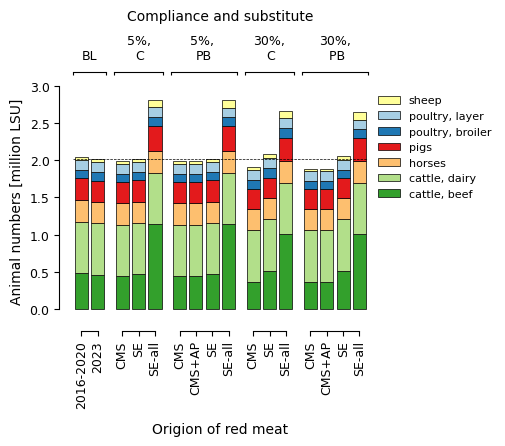

In [51]:
d = cm.impact.get_LSU(session, ['species','breed']) / 1_000_000
d.columns = pd.Index([sp if sp not in ['cattle','poultry'] else ', '.join([sp,br]) for sp,br in d.columns], name='type')
d = d.T.groupby('type').sum().T
d = d.set_index(make_scn_idx(d.index))

from matplotlib.colors import ListedColormap
colors = ['#33a02c','#b2df8a', '#fdbf6f', '#e31a1c', '#1f78b4','#a6cee3', '#ffff99']

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Animal numbers [million LSU]',
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2,
    ylim=(-0.1,3)
)
style_bar(ax, d)
plt.savefig('output/figs/LSU.png',dpi=200,bbox_inches='tight')
plt.show()
d.to_csv('output/LSU_million.csv')

In [19]:
d.sum(axis=1)

Compliance  Origin, meat  Substitute
BL          2016-2020                   2.042506
            2023                        2.009537
5%          CMS           C             1.992328
                          PB            1.988976
            CMS+AP        PB            1.988976
            SE            C             2.020924
                          PB            2.017572
            SE-all        C             2.813241
                          PB            2.809889
30%         CMS           C             1.906244
                          PB            1.886128
            CMS+AP        PB            1.886168
            SE            C             2.077326
                          PB            2.057210
            SE-all        C             2.661477
                          PB            2.641361
dtype: float64

In [20]:
d.sum(axis=1).pipe(lambda df: df.sub(df.loc[scn_tuple(BL_SCN[1])]).div(df.loc[scn_tuple(BL_SCN[1])])*100)

Compliance  Origin, meat  Substitute
BL          2016-2020                    1.640639
            2023                         0.000000
5%          CMS           C             -0.856352
                          PB            -1.023189
            CMS+AP        PB            -1.023187
            SE            C              0.566647
                          PB             0.399810
            SE-all        C             39.994481
                          PB            39.827644
30%         CMS           C             -5.140137
                          PB            -6.141159
            CMS+AP        PB            -6.139171
            SE            C              3.373356
                          PB             2.372334
            SE-all        C             32.442295
                          PB            31.441273
dtype: float64

In [21]:
display((d-d.loc[scn_tuple(BL_SCN[1])]).div(d.loc[scn_tuple(BL_SCN[1])], axis=1).mul(100).style.format(precision=1))

In [22]:
d = session.get_attr('g','x_animals',['species','sub_system']).loc[:,'sheep']

display(100-d.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)['other sheep'])
d.drop('other sheep', axis=1)\
.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)\
.pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))

scn  year
SLV  0       62.909232
     1       59.989726
     1110    59.592290
     1120    59.592275
     1121    59.592182
     1210    61.496145
     1220    61.496112
     1310    83.247431
     1320    83.247431
     2110    57.439050
     2120    57.439034
     2121    57.418113
     2210    67.452810
     2220    67.452810
     2310    82.010096
     2320    82.010096
Name: other sheep, dtype: float64

sub_system  autumn lamb  spring lamb  winter lamb
scn year                                         
SLV 0         -0.193390     0.107772     0.085619
    1          0.000000     0.000000     0.000000
    1110      -0.341135     0.190106     0.151029
    1120      -0.341148     0.190114     0.151035
    1121      -0.341228     0.190158     0.151070
    1210      -0.322720     0.179844     0.142876
    1220      -0.322748     0.179859     0.142888
    1310       3.079956    -0.179682    -2.900273
    1320       3.079956    -0.179682    -2.900273
    2110      -0.584414     0.325680     0.258734
    2120      -0.584429     0.325688     0.258741
    2121       1.086332    -1.353418     0.267086
    2210       3.498133     0.048414    -3.546547
    2220       3.498133     0.048414    -3.546547
    2310       3.058668    -0.191294    -2.867375
    2320       3.058668    -0.191294    -2.867375

# Climate impact

Default


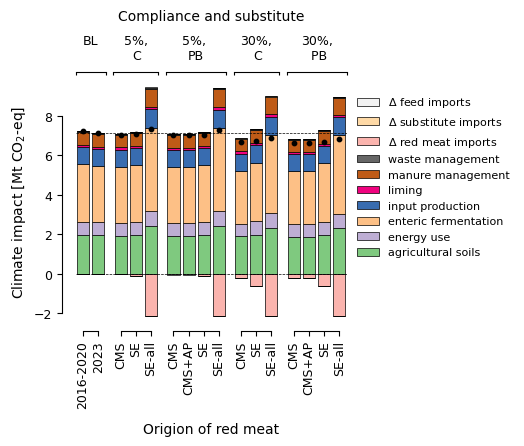

Only Irish suckler cows


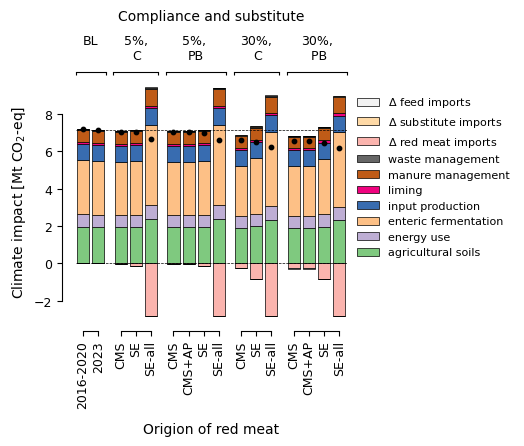

In [48]:
from matplotlib.colors import ListedColormap

d = (
    cm.impact.get_GHG(session, CO2eq=CO2e_method)
    .drop('organic soils', level='sub-process', axis=1)
    
    .T.groupby('process').sum().T
    .rename(columns={'waste and circularity':'waste management'})
) / 1_000_000_000
d1 = (
    d
    .join(food_import_CO2e / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
)
d2 = (
    d
    .join(food_import_CO2e_sens / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
) 

d1.set_index(make_scn_idx(d1.index), inplace=True)
d2.set_index(make_scn_idx(d2.index), inplace=True)

for dx in [d1,d2]:

    if dx is d1:
        print('Default')
        dx.to_csv('output/climate_MtCO2eq.csv')
    if dx is d2:
        print('Only Irish suckler cows')
        dx.to_csv('output/climate_Irish_beef_MtCO2eq.csv')
    len(dx.columns) - 3
    colors = [plt.colormaps['Accent'](i/(len(dx.columns)-3-1)) for i in range(len(dx.columns)-3)]\
        + [plt.colormaps['Pastel1'](i/2) for i in range(3)]
    
    fig,ax = plt.subplots(figsize=(3.5,3))
    ax,axgs = cm.plot.bar(
        dx,
        ax=ax,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel='Climate impact [Mt CO$_2$-eq]',
        **bar_style2
    )
    style_bar(ax, dx)
    plt.savefig(f'output/figs/climate{"_irish" if dx is d2 else ""}.png',dpi=200,bbox_inches='tight')
    plt.show()
    
    display((
        dx.sum(axis=1)
        / dx.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

    display((
        dx.iloc[:,:-3].sum(axis=1)
        / dx.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

## Emissions per GHG

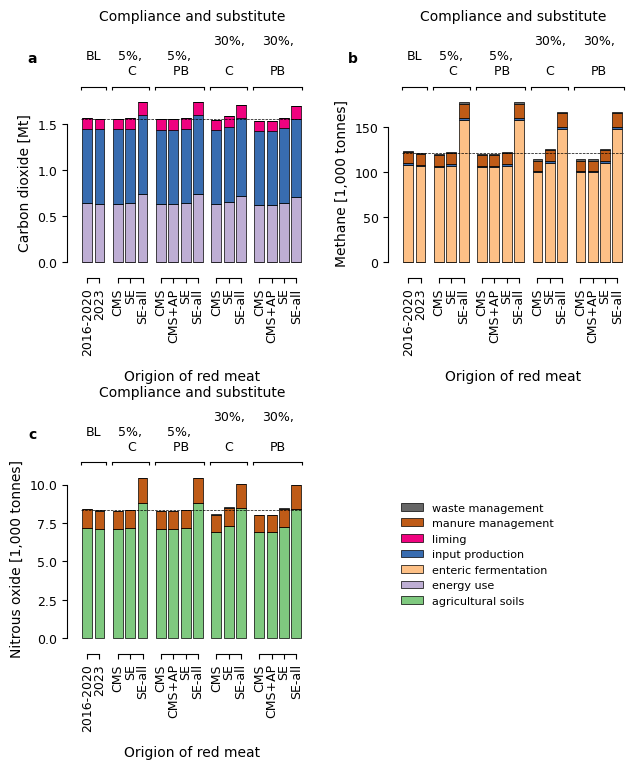

In [49]:
d = (
    cm.impact.get_GHG(session, CO2eq=False)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'CH4bio':'CH4', 'CH4fos':'CH4','N2Oind':'N2O'})
    .T.groupby(['compound','process']).sum().T
    .rename(columns={'waste and circularity':'waste management'})
    .stack().fillna(0).unstack()
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig, axs = plt.subplots(2,2, figsize=(7,7), gridspec_kw=dict(hspace=1.3, wspace=0.45))
axs = axs.flatten()

colors = [plt.colormaps['Accent'](i/(len(d.columns.unique('process'))-1)) for i in range(len(d.columns.unique('process')))]
labs = {
    'CO2' : 'Carbon dioxide [Mt]',
    'CH4' : 'Methane [1,000 tonnes]',
    'N2O' : 'Nitrous oxide [1,000 tonnes]',
}

factors = {
    'CO2' : 1 / 1_000_000_000, # Mt
    'CH4' : 1 / 1_000_000, # kt
    'N2O' : 1 / 1_000_000, # kt
}

for cmp,ax in zip(['CO2','CH4','N2O'], axs):
    dx = d.loc[:,cmp] * factors[cmp]
    cm.plot.bar(
        dx,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel=labs[cmp],
        **bar_style2,
        ax=ax
    )
    style_bar(ax, dx)
    if ax != axs[2]:
        ax.legend().set_visible(False)
    else:
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1.4,0.9), frameon=False
        )

axs[-1].axis('off')
annotate_axs(axs[0:-1])

# plt.tight_layout()
plt.savefig('output/figs/GHG.png',dpi=200,bbox_inches='tight')
plt.show()

## Land use change

In [25]:
beef_cw = food_import_chg['Bovine meat and products'] / 0.695
beef_Ireland_LUC = beef_cw * 0.08 # 0.08 kg CO2/kgCW (Moberg et al. 2019)
beef_LatAm_LUC = beef_cw * 43 # 43 kg CO2/kgCW (Pendrill et al. 2019)
beef_import_LUC = pd.concat([beef_Ireland_LUC,beef_LatAm_LUC], axis=1)
beef_import_LUC.columns = ['Ireland','Latin America']
beef_import_LUC.index = make_scn_idx(beef_import_LUC.index)

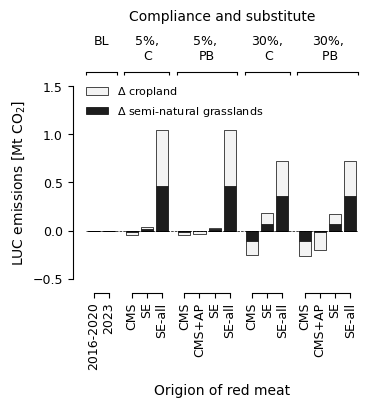

Compliance  Origin, meat  Substitute
BL          2016-2020                   0.000000
            2023                        0.000000
5%          CMS           C            -0.042563
                          PB           -0.043524
            CMS+AP        PB           -0.036078
            SE            C             0.031787
                          PB            0.030829
            SE-all        C             1.041457
                          PB            1.040491
30%         CMS           C            -0.259164
                          PB           -0.264989
            CMS+AP        PB           -0.204654
            SE            C             0.181189
                          PB            0.174358
            SE-all        C             0.727201
                          PB            0.721657
dtype: float64

LUC [Mt CO2] from changed beef imports


Ireland  Latin America
Compliance Origin, meat Substitute                         
BL         2016-2020                0.000000       0.000000
           2023                     0.000000       0.000000
5%         CMS          C          -0.000061      -0.032788
                        PB         -0.000061      -0.032788
           CMS+AP       PB         -0.000061      -0.032788
           SE           C          -0.000194      -0.104067
                        PB         -0.000194      -0.104067
           SE-all       C          -0.003872      -2.081340
                        PB         -0.003872      -2.081340
30%        CMS          C          -0.000366      -0.196729
                        PB         -0.000366      -0.196729
           CMS+AP       PB         -0.000366      -0.196729
           SE           C          -0.001162      -0.624402
                        PB         -0.001162      -0.624402
           SE-all       C          -0.003872      -2.081340
                        PB         -0.003872      -2.081340

In [50]:
fig,ax = plt.subplots(figsize=(3.5,2.5))

d1 = swe_LUC.rename(
    {'$\Delta$ semi-natural grasslands':
     '$\Delta$ semi-natural\ngrasslands'}
    , axis=1
) / 1_000_000_000
d1 = swe_LUC.iloc[:,[1,0]] / 1_000_000_000
d1.index = make_scn_idx(d1.index)

cm.plot.bar(
    d1,
    ax=ax,
    ylabel='LUC emissions [Mt CO$_2$]',
    **bar_style2,
    totmarker='none',
    cmap='Greys',
    ylim = (-0.5,1.5)
)
ax.legend(
    ncol=1, fontsize=8, reverse=True,
    bbox_to_anchor=(-0.04,0.92), frameon=False,
    loc = 'center left'
)
plt.savefig('output/figs/LUC.png',dpi=200,bbox_inches='tight')
plt.show()
d1.to_csv('output/LUC_Swe_MtCO2.csv')

display(d1.sum(axis=1))
print('LUC [Mt CO2] from changed beef imports')
display(beef_import_LUC * (10/20) / 1_000_000_000)

# Ammonia

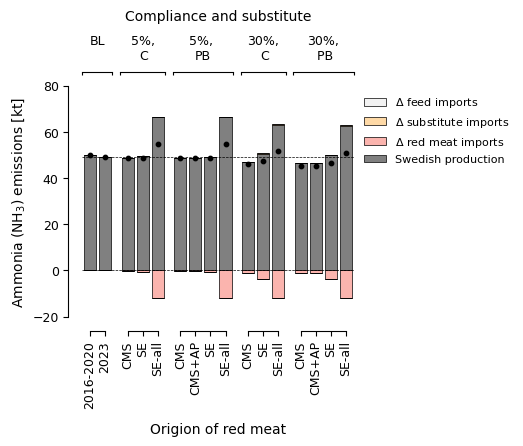

In [57]:
from matplotlib.colors import ListedColormap
colors = ['grey']\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    cm.impact.get_emissions(session)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'waste and circularity':'waste management'})
    .T.groupby('compound').sum().loc['NH3-N'].T
    .mul((14+3)/14)
    .rename('Swedish production').to_frame()
    .join(food_import_ammonia)
    .join(feed_import_ammonia)
     / 1_000_000
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Ammonia (NH$_3$) emissions [kt]',
    cmap=ListedColormap(name='X', colors=colors),
    ylim = (-20,80),
    **bar_style2
)

style_bar(ax, d)
d.to_csv('output/NH3_kt.csv')
plt.savefig('output/figs/NH3.png',dpi=200,bbox_inches='tight')
plt.show()

display((
    d.sum(axis=1)
    / d.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

display((
    d.iloc[:,:-3].sum(axis=1)
    / d.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

# Fertilisers

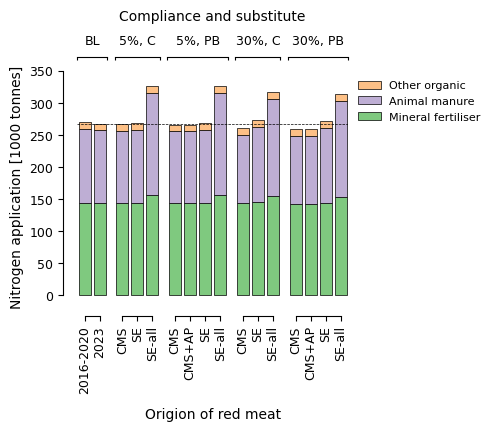

In [45]:
d = pd.concat([
    session.get_attr('c','fertiliser.mineral_N','none').rename('Mineral fertiliser'),
    session.get_attr('c','fertiliser.manure_N','none').rename('Animal manure'),
    session.get_attr('c','fertiliser.organic_N','none').rename('Other organic')
], axis=1) / 1_000_000
d.index = make_scn_idx(d.index)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Nitrogen application [1000 tonnes]',
    ylim=(-10,350),
    **bar_style
)

style_bar(ax, d)
d.to_csv('output/N_fert_ktN.csv')
plt.savefig('output/figs/N_fert.png',dpi=200,bbox_inches='tight')
plt.show()

# Maps

In [29]:
def rescale_colormap(cmap, min_val=0.0, max_val=1.0):
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    return colors.LinearSegmentedColormap.from_list(
        "new_cmap", cmap(np.linspace(min_val, max_val, 256))
    )

map_style1 = {
    'cmap' : 'BrBG',
    'edgecolor' : 'grey'
}
map_style2 = {
    'cmap' : rescale_colormap('BrBG',0.5,1),
    'edgecolor' : 'grey'
}



## Total Cropland and Semi-natural grasslands

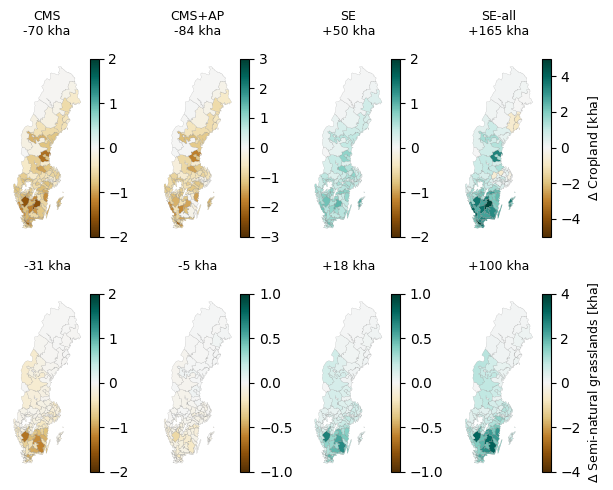

In [47]:
d = (
    session.get_attr('c','area',{'crop':'land_use', 'region':None})
    .drop('greenhouse', axis=1)
    .pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))
    .droplevel('scn')
) / 1_000

scns = ['2120','2121','2220','2320']

fig, axs = plt.subplots(2,len(scns), figsize=(1.6*len(scns),5))#, gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.1,)})
for i, lu in enumerate(d.columns.unique('land_use')):
    for j, scn in enumerate(scns): 
        ax = axs[i,j]
        map_data = d.loc[scn,lu]
        lim = np.ceil(map_data.abs().max().max())
        cm.plot.map_from_series(
            map_data,
            ax=ax,
            vmin = -lim,
            vmax = lim,
            **map_style1
        )
        ax.axis('off')
        title_str = ''
        if i == 0:
            title_str += scn_tuple(scn)[1] + '\n'
        title_str += f'{map_data.sum():+.0f} kha'
        ax.set_title(title_str, size=9)
        
        if scn == scns[-1]:
            cbar = ax.get_figure().axes[-1]
            cbar.set_ylabel(f'$\Delta$ {lu.capitalize()} [kha]', fontsize=9)
        

plt.tight_layout()
plt.savefig('output/figs/map_land_use.png',dpi=200,bbox_inches='tight')
plt.show()

## Different crops

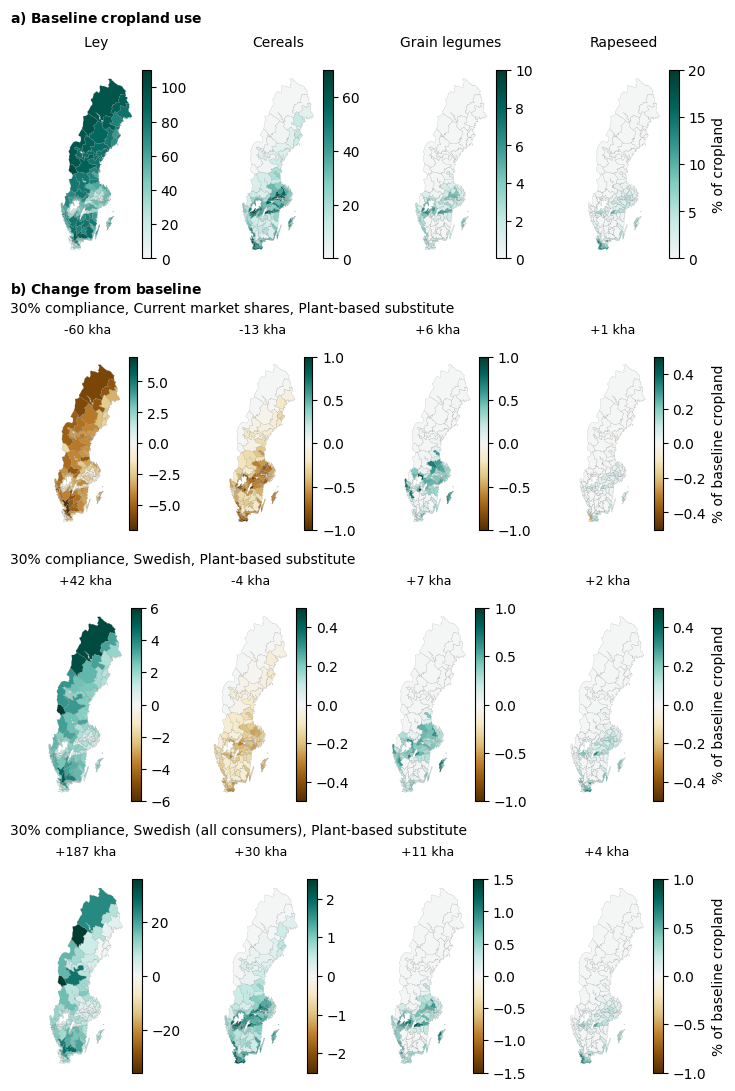

In [54]:
scns = ['2120','2220','2320']
scn_titles = {0 : r'$\bf{a)}$ $\bf{Baseline}$ $\bf{cropland}$ $\bf{use}$'}

for i, scn in enumerate(scns):
    if i == 0:
        title_str = r'$\bf{b)}$ $\bf{Change}$ $\bf{from}$ $\bf{baseline}$'+'\n'
    else:
        title_str = ''
    tpl = scn_tuple(scn, long=True)
    title_str += f'{tpl[0]} compliance, {tpl[1]}, {tpl[2]} substitute'.replace("\n","")
    scn_titles.update(
        {i+1:title_str}
    )

plot_data = (
    session.get_attr('C', 'area', {'crop':['land_use','crop_group'], 'region':None})
    .loc['SLV','cropland']
    .T
    .rename({'Cereals, winter':'Cereals', 'Cereals, spring':'Cereals'})
    .groupby(['crop_group','region'])
    .sum()
)

plot_data1_nat = plot_data.groupby('crop_group').sum()/1000
plot_data1 = plot_data.div(plot_data.groupby('region').sum()[BL_SCN[1]], axis=0) * 100

plot_data2 = plot_data1.sub(plot_data1[BL_SCN[1]], axis=0)
plot_data2_nat = plot_data1_nat.sub(plot_data1_nat[BL_SCN[1]], axis=0)

crps = ['Ley','Cereals','Grain legumes','Brassicaceae']

h = 2.7
w = 1.8
fig = plt.figure(constrained_layout=True, figsize=(w*len(crps), h+h*len(scns)))
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(scns)+1, ncols=1)
for row, subfig in enumerate(subfigs):
    
    axs = subfig.subplots(nrows=1, ncols=len(crps))
    subfig.suptitle(scn_titles[row], x=0, ha='left', size=10)
    if row==0:
        for crp, ax in zip(crps,axs):
            map_data = plot_data1['0'].loc[crp]
            lim = np.ceil(map_data.max()/10)*10
            leg_str = '% of cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=0, vmax=lim, **map_style2, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            ax.set_title('Rapeseed' if crp == 'Brassicaceae' else '   Ley   ' if crp=='Ley' else crp, size=10)
        
    else:
        scn = scns[row-1]
        for crp, ax in zip(crps,axs):
            map_data = plot_data2[scn].loc[crp]
            # lim = np.ceil(abs(plot_data2[scns].loc[crp]).quantile(0.99).max())
            lim = np.ceil(abs(map_data).quantile(0.99).max()*2)/2
            leg_str = '% of baseline cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=-lim, vmax=lim, **map_style1, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            nat_chg = plot_data2_nat[scn][crp]
            ax.set_title(f'{nat_chg:+.0f} kha', size=9)

plt.savefig('output/figs/map_per_crop.png',dpi=200,bbox_inches='tight')
plt.show()

In [32]:
# Changes in crop areas [1000 ha]
t1 = plot_data1_nat.T.pipe(lambda df: df.sub(df.loc['1'], axis=1))
t1.index = make_scn_idx(t1.index)
t1 = pd.concat({' 1000 ha': t1}, names=['unit'], axis=1)

t2 = plot_data1_nat.T.pipe(lambda df: df.sub(df.loc['1'], axis=1).div(df.loc['1'], axis=1)*100)
t2.index = make_scn_idx(t2.index)
t2 = pd.concat({'%': t2}, names=['unit'], axis=1)

t = pd.concat([t1,t2], axis=1).T.groupby(['crop_group','unit']).sum().T
t[['Ley','Cereals','Brassicaceae','Grain legumes']]

crop_group                                 Ley               Cereals  \
unit                                   1000 ha          %    1000 ha   
Compliance Origin, meat Substitute                                     
BL         2016-2020                 17.837414   1.714980   2.453984   
           2023                       0.000000   0.000000   0.000000   
5%         CMS          C           -10.108109  -0.971845  -0.629889   
                        PB          -10.102302  -0.971287  -2.177469   
           CMS+AP       PB          -11.801957  -1.134701  -2.174297   
           SE           C             7.219339   0.694104   0.785251   
                        PB            7.221319   0.694295  -0.761008   
           SE-all       C           272.750194  26.223602  46.236306   
                        PB          272.744799  26.223083  44.720961   
30%        CMS          C           -59.898063  -5.758907  -3.767427   
                        PB          -59.603356  -5.730572 -13.124539   
           CMS+AP       PB          -73.604391  -7.076703 -13.030951   
           SE           C            42.143325   4.051875   5.199871   
                        PB           41.678932   4.007226  -3.903976   
           SE-all       C           187.462635  18.023619  38.920661   
                        PB          187.471465  18.024468  29.979685   

crop_group                                   Brassicaceae            \
unit                                       %      1000 ha         %   
Compliance Origin, meat Substitute                                    
BL         2016-2020                0.292344    -0.186243 -0.226835   
           2023                     0.000000     0.000000  0.000000   
5%         CMS          C          -0.075039     0.335828  0.409022   
                        PB         -0.259403     0.122901  0.149687   
           CMS+AP       PB         -0.259025     0.120308  0.146529   
           SE           C           0.093547     0.499645  0.608542   
                        PB         -0.090659     0.286751  0.349248   
           SE-all       C           5.508154     3.756744  4.575526   
                        PB          5.327631     3.544358  4.316851   
30%        CMS          C          -0.448815     2.009643  2.447645   
                        PB         -1.563533     0.729887  0.888966   
           CMS+AP       PB         -1.552384     0.711917  0.867079   
           SE           C           0.619463     3.433971  4.182405   
                        PB         -0.465083     2.293327  2.793157   
           SE-all       C           4.636638     5.318927  6.478187   
                        PB          3.571495     4.063662  4.949337   

crop_group                         Grain legumes             
unit                                     1000 ha          %  
Compliance Origin, meat Substitute                           
BL         2016-2020                    0.615107   1.116508  
           2023                         0.000000   0.000000  
5%         CMS          C              -0.355943  -0.646087  
                        PB              0.990114   1.797200  
           CMS+AP       PB              0.990894   1.798617  
           SE           C              -0.148690  -0.269894  
                        PB              1.196360   2.171568  
           SE-all       C               5.637464  10.232815  
                        PB              6.944750  12.605730  
30%        CMS          C              -2.138990  -3.882577  
                        PB              6.063746  11.006579  
           CMS+AP       PB              6.061671  11.002813  
           SE           C              -1.115626  -2.025023  
                        PB              6.887075  12.501040  
           SE-all       C               3.331311   6.046813  
                        PB             11.205331  20.339302

In [33]:
# Share of grain legumes of cropland
t = (plot_data.loc['Grain legumes'] / plot_data.groupby('region').sum() * 100).apply(lambda x: pd.Series({
    'mean':x.mean(),
    'max':x.max(),
    'Sweden':(plot_data.loc['Grain legumes'].sum() / plot_data.sum() * 100)[x.name]
})).T
t.index = make_scn_idx(t.index)
t

mean       max    Sweden
Compliance Origin, meat Substitute                              
BL         2016-2020                1.720614  6.770236  2.375029
           2023                     1.716299  6.717726  2.371101
5%         CMS          C           1.712977  6.684852  2.367565
                        PB          1.759533  6.757276  2.426155
           CMS+AP       PB          1.761049  6.759653  2.427979
           SE           C           1.705006  6.691932  2.355713
                        PB          1.751032  6.764051  2.413754
           SE-all       C           1.720391  6.905680  2.346452
                        PB          1.758293  6.994888  2.397362
30%        CMS          C           1.695576  6.518968  2.348411
                        PB          1.994240  6.959833  2.713869
           CMS+AP       PB          2.009989  6.986779  2.730712
           SE           C           1.646123  6.515083  2.271825
                        PB          1.916004  6.962290  2.611289
           SE-all       C           1.713467  6.779892  2.345513
                        PB          1.954329  7.301489  2.664220

## Share of max land use

In [34]:
max_lu = session.get_attr('r','max_land_use',['land_use','region'])
lu = session.get_attr('c','area',{'crop':'land_use', 'region':None})
d = (
    (lu/max_lu)
    .clip(upper=0.999)
    .replace({0.999:np.nan})
    .drop('greenhouse', axis=1)
    .droplevel('scn')
) * 100

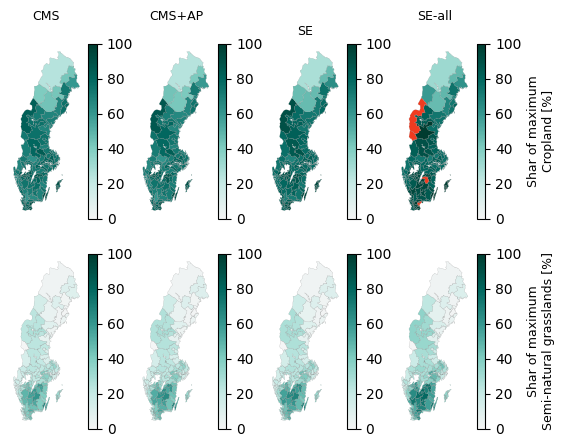

In [35]:
scns = ['2120','2121','2220','2320']

fig, axs = plt.subplots(2,len(scns), figsize=(1.6*len(scns),5))#, gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.1,)})
for i, lu in enumerate(d.columns.unique('land_use')):
    for j, scn in enumerate(scns): 
        ax = axs[i,j]
        map_data = d.loc[scn,lu]
        lim = np.ceil(map_data.abs().max().max())
        cm.plot.map_from_series(
            map_data,
            ax=ax,
            vmin=0,
            vmax=100,
            missing_kwds={"color": "#f03b20"},
            **map_style2
        )
        ax.axis('off')
        if i == 0:
            ax.set_title(scn_tuple(scn)[1], size=9)
        
        if scn == scns[-1]:
            cbar = ax.get_figure().axes[-1]
            cbar.set_ylabel(f'Shar of maximum\n{lu.capitalize()} [%]', fontsize=9)
        

# plt.tight_layout()
plt.show()

# Use of cereals

In [37]:
d = (
    session.get_attr('c','production_per_use',{'crop':'crop_group2','demand':None})
    .loc[:,'Cereals']
    .rename(columns=lambda x: 'feed' if 'feed' in x else x)
    .T.groupby('demand').sum().T
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d.set_index(make_scn_idx(d.index), inplace=True)
d['food+export'] = d['food'] + d['export']
d

demand                                 export       feed       food  \
Compliance Origin, meat Substitute                                    
BL         2016-2020                26.856980  41.054960  16.318907   
           2023                     26.924190  40.916843  16.359745   
5%         CMS          C           26.936440  40.892159  16.367189   
                        PB          26.992779  40.775123  16.401422   
           CMS+AP       PB          26.992683  40.775323  16.401363   
           SE           C           26.893280  40.981188  16.340963   
                        PB          26.949436  40.864525  16.375085   
           SE-all       C           25.565828  43.721547  15.534374   
                        PB          25.616147  43.616906  15.564948   
30%        CMS          C           26.997469  40.769218  16.404271   
                        PB          27.340868  40.056191  16.612928   
           CMS+AP       PB          27.337354  40.063535  16.610793   
           SE           C           26.723848  41.333803  16.238013   
                        PB          27.053899  40.648173  16.438559   
           SE-all       C           25.740516  43.363463  15.640518   
                        PB          26.044842  42.730665  15.825433   

demand                               non-food      seed  food+export  
Compliance Origin, meat Substitute                                    
BL         2016-2020                12.338642  3.430511    43.175887  
           2023                     12.369520  3.429703    43.283934  
5%         CMS          C           12.375148  3.429064    43.303629  
                        PB          12.401031  3.429645    43.394201  
           CMS+AP       PB          12.400987  3.429645    43.394046  
           SE           C           12.355319  3.429250    43.234243  
                        PB          12.381119  3.429835    43.324521  
           SE-all       C           11.745461  3.432790    41.100202  
                        PB          11.768578  3.433421    41.181095  
30%        CMS          C           12.403186  3.425857    43.401739  
                        PB          12.560950  3.429063    43.953796  
           CMS+AP       PB          12.559336  3.428981    43.948147  
           SE           C           12.277479  3.426858    42.961860  
                        PB          12.429111  3.430257    43.492459  
           SE-all       C           11.825716  3.429787    41.381034  
                        PB          11.965530  3.433531    41.870275

# TEST SAFAD

In [38]:
if False:
    codes = pd.read_csv('SAFAD_data/SAFAD IP Recipes.csv')['Food code'].unique()
    len(codes)
    
    for c in codes:
        try:
            print(c,end=': ')
            print(round(
                SAFAD.get_footprints(c)['Carbon footprint, primary production'] /
                SAFAD.get_GHG(c, CO2eq='GWP100 AR6').drop('Transport', level='process').sum(),
                2
            ))
        except:
            print('Failed')

In [39]:
session

,calculated
year,
0,2025-03-21 13:25:09
1,2025-03-21 13:25:05
1110,2025-03-21 13:24:35
1120,2025-03-21 13:24:20
1121,2025-03-21 13:25:00
1210,2025-03-21 13:24:32
1220,2025-03-21 13:24:18
1310,2025-03-21 13:25:00
1320,2025-03-21 13:25:04
